# Распознавание объектов на изображениях из набора данных CIFAR-10

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (Файл -> Создать копию на Диске). Свою копию вы сможете изменять и запускать.

Учебный курс "[Программирование глубоких нейронных сетей на Python](https://openedu.ru/course/urfu/PYDNN/)".

<a target="_blank" href="https://colab.research.google.com/github/sozykin/dlpython_course/blob/master/cnn/pytorch/cifar10.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Загружаем набор данных

Определяем инструмент предварительной обработки изображений из набора данных

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor()
    ])

Загружаем наборы данных для обучения и тестирования

In [3]:
trainset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='data', train=False,
                                       download=True, transform=transform)


100.0%


Создаем загрузчики данных

In [6]:
# Размер мини-выборки
batch_size = 256

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=batch_size,
                                         shuffle=False)

Имена классов

In [7]:
classes = ('самолет', 'машина', 'птица', 'кот',
           'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик')

Просматриваем примеры изображений



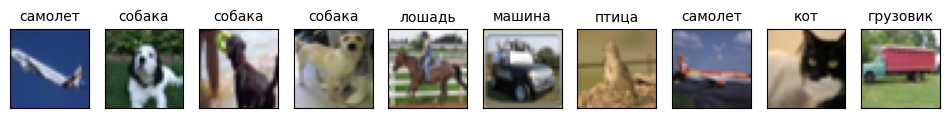

In [8]:
nsamples=10

imgs, labels = next(iter(trainloader))

fig=plt.figure(figsize=(12,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    img = imgs[i] / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(classes[labels[i]], fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Создаем модель




In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [10]:
device

'cuda'

Описываем класс для модели

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(256*8*8, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)

Создаем модель на основе описанного класса

In [ ]:
model = NeuralNetwork().to(device)


NeuralNetwork(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=16384, out_features=1024, bias=True)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=512, bias=True)
    (10): ReLU()
    (11): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [15]:
model

NeuralNetwork(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=16384, out_features=1024, bias=True)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=512, bias=True)
    (10): ReLU()
    (11): Linear(in_features=512, out_features=10, bias=True)
  )
)

## Обучаем модель

Задаем функцию ошибки - категориальная перекрестная энтропия



In [16]:
loss_fn = nn.CrossEntropyLoss()

Задаем оптимизатор

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Определяем функцию для обучения нейронной сети



In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Включаем режим обучения
    model.train()
    # В цикле получаем все мини-выборки
    # X - изображение
    # y - номер класса
    for batch, (X, y) in enumerate(dataloader):
        # Передаем данные на устройство
        X, y = X.to(device), y.to(device)
        # Обнуляем значения градиента
        optimizer.zero_grad()

        # Расчитываем данные на выходе из нейронной сети
        pred = model(X)

        # Расчитываем значение ошибки
        loss = loss_fn(pred, y)

        # Обратное распространение ошибки
        loss.backward()

        # Выполняем шаг обучения (изменение весов)
        optimizer.step()

        # Печатаем прогресс каждые 50 мини-выборок
        if batch % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Ошибка: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Определяем функцию для проверки качества работы нейронной сети на тестовом наборе данных

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Включаем режим оценки качества модели
    model.eval()
    # Начальные значения
    test_loss, correct = 0, 0
    # Для оценки качества работы не нужно рассчитывать градиент
    with torch.no_grad():
        # В цикле проходим по мини-выборкам из тестового набора данных
        for X, y in dataloader:
            # Передаем данные на устройство
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Качество на тестовом наборе данных: \n Доля правильных ответов: {(100*correct):>0.1f}%, средняя ошибка: {test_loss:>8f} \n")

Обучаем модель в течение 10 эпох



In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Эпоха {t+1}\n-------------------------------")
    # Обучение модели
    train(trainloader, model, loss_fn, optimizer)
    # Оценка качества работы на тестовом объеме данных
    test(testloader, model, loss_fn)
print("Обучение завершено!")

Эпоха 1
-------------------------------
Ошибка: 2.303020  [  256/50000]
Ошибка: 1.905954  [13056/50000]
Ошибка: 1.720232  [25856/50000]
Ошибка: 1.505373  [38656/50000]
Качество на тестовом наборе данных: 
 Доля правильных ответов: 49.2%, средняя ошибка: 1.412370 

Эпоха 2
-------------------------------
Ошибка: 1.474615  [  256/50000]
Ошибка: 1.236939  [13056/50000]
Ошибка: 1.205344  [25856/50000]
Ошибка: 1.098535  [38656/50000]
Качество на тестовом наборе данных: 
 Доля правильных ответов: 63.1%, средняя ошибка: 1.026261 

Эпоха 3
-------------------------------
Ошибка: 0.974184  [  256/50000]
Ошибка: 0.906735  [13056/50000]
Ошибка: 0.988402  [25856/50000]
Ошибка: 0.869275  [38656/50000]
Качество на тестовом наборе данных: 
 Доля правильных ответов: 68.6%, средняя ошибка: 0.885442 

Эпоха 4
-------------------------------
Ошибка: 0.879549  [  256/50000]
Ошибка: 0.754406  [13056/50000]
Ошибка: 0.766176  [25856/50000]
Ошибка: 0.643175  [38656/50000]
Качество на тестовом наборе данных: 


## Сохранение обученной модели



Параметры модели

In [ ]:
model.state_dict()

OrderedDict([('network.0.weight',
              tensor([[[[-1.6138e-01,  1.7496e-01, -1.1263e-01],
                        [ 1.6202e-01,  1.9628e-01,  1.7669e-01],
                        [ 1.2722e-01,  2.4790e-02, -7.1190e-02]],
              
                       [[-1.9344e-01, -1.4006e-02, -2.8429e-02],
                        [-8.2738e-02,  2.0179e-01,  3.2212e-02],
                        [ 4.0644e-02, -1.1436e-01,  1.2649e-01]],
              
                       [[-8.1036e-02,  1.3174e-01,  8.0093e-02],
                        [-7.2276e-02, -1.5996e-01,  1.5380e-01],
                        [ 1.0363e-01, -1.7346e-01, -2.2918e-01]]],
              
              
                      [[[ 1.1511e-01,  9.2250e-03,  6.2382e-02],
                        [-1.9252e-02,  1.6367e-01,  7.1226e-02],
                        [-6.2349e-02, -9.5559e-02,  1.4525e-01]],
              
                       [[-3.2396e-02, -3.8722e-02, -1.1051e-01],
                        [-9.6706e-03,  1.

In [ ]:
torch.save(model.state_dict(), "model.pth")

## Загрузка модели



In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

## Распознавание изображений из тестового набора данных



In [ ]:
model.eval()

NeuralNetwork(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_featur

In [ ]:
x, y = testset[5]

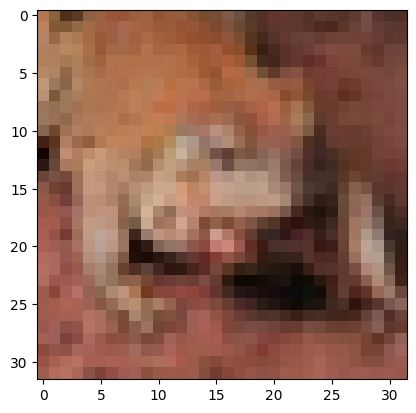

In [ ]:
img = x / 2 + 0.5
plt.imshow(img.permute(1, 2, 0))

Запускаем распознавание

In [ ]:
with torch.no_grad():
    x = x.unsqueeze(0).to(device)
    pred = model(x)

Результаты распознавания

In [ ]:
pred

tensor([[ -7.6016, -10.4587,  -3.0140,   0.3230,  -2.7575,  -3.0054,  11.4020,
          -7.5687,  -8.9567,  -5.0741]], device='cuda:0')

Номер класса

In [ ]:
pred[0].argmax(0)

tensor(6, device='cuda:0')

Название класса

In [ ]:
classes[pred[0].argmax(0)]

'лягушка'

Правильный ответ

In [ ]:
y

6

In [ ]:
classes[y]

'лягушка'

## Распознаем дополнительное изображение

In [ ]:
from PIL import Image

In [ ]:
img = Image.open("plane.jpg")

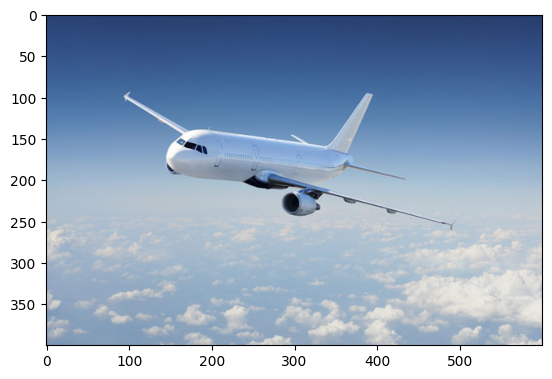

In [ ]:
plt.imshow(img)

## Выполняем предварительную обработку изображения

In [ ]:
transform = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
batch = transform(img).unsqueeze(0)

In [ ]:
batch

tensor([[[[-0.6784, -0.6706, -0.6627,  ..., -0.6706, -0.6784, -0.6784],
          [-0.6549, -0.6549, -0.6471,  ..., -0.6549, -0.6549, -0.6549],
          [-0.6392, -0.6392, -0.6314,  ..., -0.6314, -0.6314, -0.6314],
          ...,
          [ 0.1765,  0.1137,  0.0745,  ...,  0.4196,  0.5373,  0.6706],
          [ 0.2784,  0.1686,  0.0980,  ...,  0.3882,  0.3333,  0.2784],
          [ 0.1059,  0.0431,  0.0431,  ...,  0.4039,  0.4667,  0.3647]],

         [[-0.4745, -0.4667, -0.4667,  ..., -0.4902, -0.4980, -0.4980],
          [-0.4431, -0.4353, -0.4431,  ..., -0.4588, -0.4588, -0.4667],
          [-0.4039, -0.4039, -0.4039,  ..., -0.4196, -0.4196, -0.4275],
          ...,
          [ 0.3098,  0.2863,  0.2706,  ...,  0.4902,  0.5765,  0.6784],
          [ 0.3569,  0.3020,  0.2706,  ...,  0.4745,  0.4353,  0.3961],
          [ 0.2549,  0.2235,  0.2314,  ...,  0.4667,  0.5216,  0.4667]],

         [[-0.0824, -0.0745, -0.0824,  ..., -0.1137, -0.1137, -0.1137],
          [-0.0275, -0.0275, -

## Выполняем классификацию изображения

Выполняем распознавание

In [ ]:
batch = batch.to(device)

In [ ]:
prediction = model(batch).squeeze(0)

Результаты распознавания

In [ ]:
prediction

tensor([ 7.7684, -7.8778,  3.2439, -2.7038, -0.9086, -5.3302, -3.4209, -6.0356,
        -2.3007, -6.8902], device='cuda:0', grad_fn=<SqueezeBackward1>)

Выбираем класс с максимальной вероятностью

In [ ]:
class_id = prediction.argmax().item()

In [ ]:
class_id

0

Название класса

In [ ]:
classes[class_id]

'самолет'